<a href="https://colab.research.google.com/github/Tubhalooter/Path-Detection-AI/blob/Unet/U_net_model_Ai_2_Cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [ ]:
# The function below is solely to filter out for classes

def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/Annotations/{}.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [ ]:
def getClassName(classID,cats):
  for i in range(len(cats)):
    if cats[i]['id'] == classID:
      return cats[i]['name']
  return None

def getImage(imageObj,img_folder, input_image_size):
  # Read and Normalise an image
  train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
  # Resize
  train_img = cv2.resize(train_img,input_image_size)
  if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a 3 channel RGB image
    return train_img
  else :
    stacked_img = np.stack((train_img)*3 , axis =-1)
    return stacked_img


def getNormalMask(imageOBJ,classes,coco,catIds,input_image_size):
  annsIds = coco.getAnnIds(imageObj['id'],catIds = catIds , iscrowd = None)
  anns= coco.loadAnns(annIds)
  cats = coco.loadCats(catIds)
  train_mask = np.zeros((input_image_size[1],input_image_size[0]))
  for a in range(len(anns)):
    className = getClassName(anns[a]['category_id'], cats)
    pixel_value = classes.index(className)+1
    new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
    train_mask = np.maximum(new_mask, train_mask)

  # Add extra dimension for parity with train_img size [X * X * 3]
  train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
  return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros((input_image_size[1],input_image_size[0]))
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask < 0.5] = 0
        new_mask[new_mask >= 0.5] = 1
        

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[1], input_image_size[0], 1)
    return train_mask


def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    
    img_folder = '{}/Images/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[1], input_image_size[0], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[1], input_image_size[0], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask


# My changes to the code:
 # I have had to change some of the code so that the values that are used with numpy are the same as cv2
 # cv2 uses an array of size(width,height) 
 # numpy uses an array of size (height, width)
 # so all the numpy arrays were inversed , 
 # quick easy fix was just specifying to use input_image_size[1] first then [0]

In [ ]:
# This code is to visualise the data from the generator
def visualizeGenerator(gen,batch_size):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)
 
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
   
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(int(batch_size/2), int(batch_size/2), subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(batch_size):# since our batch_size is 1 it will display 1 image, batch size of x will display x num of images
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                ax.imshow(mask[j][:,:,0]);
                
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

# My changes to code:
 # Added a batch_size parameter , original code just used 4 but for adaptability (and because my batch size is 1)
 # i have made it so that you can specify tha batchsize

In [ ]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        mask_aug = next(g_y)
                   
        yield img_aug, mask_aug

In [ ]:

def getImage_test(img_folder, input_image_size, batch_size):
  img = np.zeros((batch_size, input_image_size[1], input_image_size[0], 3)).astype('float')
  # Read and Normalise an image
  testdir=img_folder
  testimages = next(os.walk(testdir))[2]
  CimageDir = os.path.join(testdir,random.choice(testimages))
  test_img = io.imread(CimageDir)/255.0
  # Resize
  test_img= cv2.resize(test_img,input_image_size)
  if (len(test_img.shape)==3 and test_img.shape[2]==3): # If it is a 3 channel RGB image
    img[0] = test_img
    return img,test_img,CimageDir
  else :
    stacked_img = np.stack((test_img)*3 , axis =-1)
    img[0] = stacked_img
    return img,test_img,CimageDir


In [ ]:
# created model based of u-net as this tutorial shows  https://www.youtube.com/watch?v=68HR_eyzk00

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.layers import Input , Conv2D , MaxPooling2D , Dropout , concatenate , UpSampling2D
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
import numpy as np

IMG_WIDTH =720
IMG_HEIGHT =720
IMG_CHANNELS=3

# Build Model
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
activation = 'relu'
K_init = 'he_normal'

# Encoder

keras.backend.clear_session()
conv1 = Conv2D(16, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(inputs)
conv1 = Conv2D(16, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(pool1)
conv2 = Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(pool2)
conv3 = Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(pool3)
conv4 = Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(256, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(pool4)
conv5 = Conv2D(256, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(128, 2, activation = activation, padding = 'same', kernel_initializer = K_init)(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(merge6)
conv6 = Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(conv6)

up7 = Conv2D(64, 2, activation = activation, padding = 'same', kernel_initializer = K_init)(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(merge7)
conv7 = Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(conv7)

up8 = Conv2D(32, 2, activation = activation, padding = 'same', kernel_initializer = K_init)(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(merge8)
conv8 = Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(conv8)

up9 = Conv2D(16, 2, activation = activation, padding = 'same', kernel_initializer = K_init)(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(16, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(merge9)
conv9 = Conv2D(16, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(conv9)
conv9 = Conv2D(2, 3, activation = activation, padding = 'same', kernel_initializer = K_init)(conv9)

outputs = layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = tf.keras.Model(inputs = inputs , outputs = outputs,name = 'UNet')

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# The optimiser is the algo that improves weights, this includes backprop
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 720, 720, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 720, 720, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 720, 720, 16  2320        ['conv2d[0][0]']                 
                                )                                                              

In [ ]:
folder = "/content/drive/MyDrive/trainval"
classes=[]
mode ="train"

images,dataset_size,cocotrain= filterDataset(folder=folder,classes=None , mode = mode)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


In [ ]:
batch_size = 4
input_image_size =(1280,720)
mask_type = 'binary'

# called our data generator function , creates a datagen object yielding a batch of images and binary masks
train_gen = dataGeneratorCoco(images=images,classes=None,coco= cocotrain ,folder=folder,
                              input_image_size=input_image_size,batch_size=batch_size,
                              mode=mode,mask_type=mask_type)

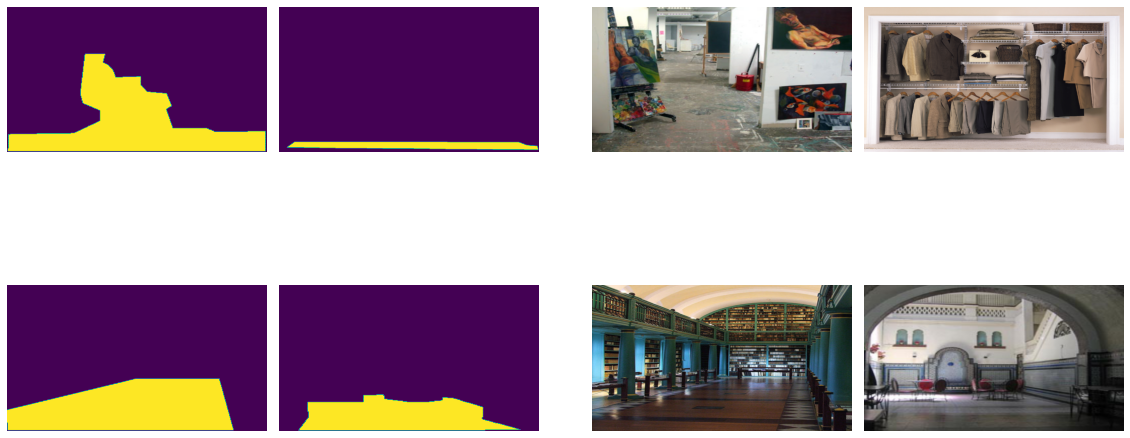

In [ ]:
visualizeGenerator(train_gen,batch_size=batch_size)

In [ ]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

# Call the function with the arguments
train_aug_gen = augmentationsGenerator(train_gen, augGeneratorArgs)

In [ ]:
visualizeGenerator(train_aug_gen,batch_size=batch_size)

In [ ]:
folder = "/content/drive/MyDrive/trainval"
classes=[]
mode ="val"

images,dataset_size,cocoval= filterDataset(folder=folder,classes=None , mode = mode)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


In [ ]:
batch_size = 4
input_image_size =(1280,720)
mask_type = 'binary'

# called our data generator function , creates a datagen object yielding a batch of images and binary masks
val_gen = dataGeneratorCoco(images=images,classes=None,coco= cocoval ,folder=folder,
                              input_image_size=input_image_size,batch_size=batch_size,
                              mode=mode,mask_type=mask_type)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


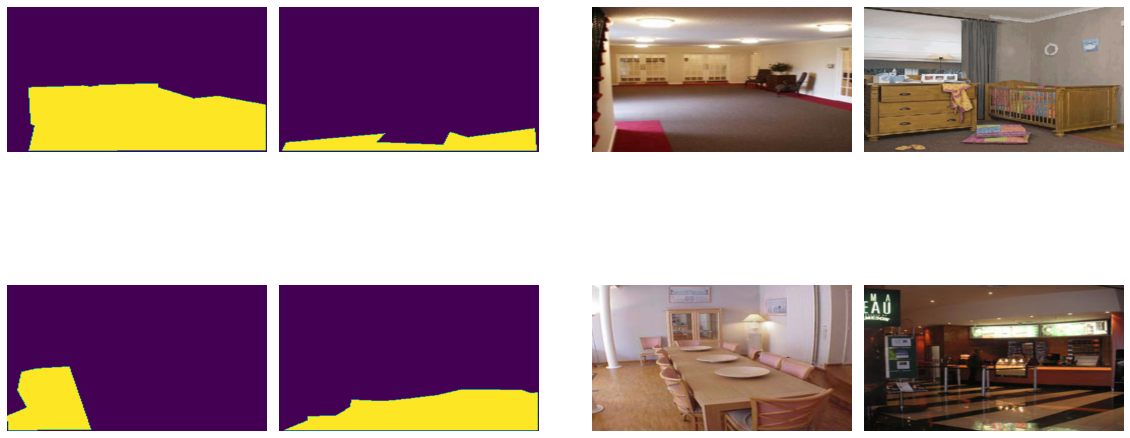

In [ ]:
visualizeGenerator(val_gen,batch_size=batch_size)

In [ ]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

# Call the function with the arguments
val_aug_gen = augmentationsGenerator(val_gen, augGeneratorArgs)

In [ ]:
visualizeGenerator(val_aug_gen,batch_size=batch_size)

In [ ]:
# And now... we train



n_epochs = 50
steps_per_epoch=242//batch_size
Validation_steps = 60 //batch_size

#callbacks = [tf.keras.callbacks.EarlyStopping(patience= 4),
                                #tf.keras.callbacks.CSVLogger("trainresults.csv")]

history = model.fit(x=train_gen,validation_data=val_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=Validation_steps,
                    epochs=n_epochs,
                    verbose=1)

In [ ]:
model.save_weights("Unet_{}_{}_1280x720.h5".format(n_epochs,batch_size))

model_json = model.to_json()
with open("model{}.json".format(batch_size), "w") as json_file:
    json_file.write(model_json)
    

In [2]:
from keras.models import model_from_json

json_file = open('/content/drive/MyDrive/Unet rev6/model4.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("/content/drive/MyDrive/Unet rev6/Unet_50_4_720x720.h5")
print("Loaded model from disk")

Loaded model from disk


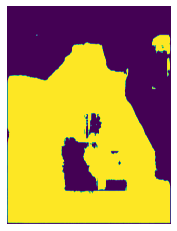

In [ ]:
batch_size = 1
input_image_size = (720,720)

bencharray = np.zeros((batch_size, input_image_size[1], input_image_size[0], 3)).astype('float')

benchimg = io.imread("/content/drive/MyDrive/IMG_0408.JPG")/255

benchimg = cv2.resize(benchimg,input_image_size)

bencharray[0] = benchimg

#benchtest= model.predict(bencharray)

benchtest = loaded_model.predict(bencharray)

benchout = benchtest[0][:,:,0]
benchout = cv2.resize(benchout,(3024,4032))

benchout =(benchout >0.5).astype("float")

plt.imshow(benchout)
plt.axis("off")
plt.show()

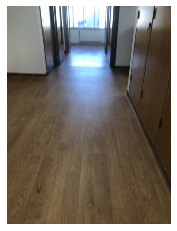

In [ ]:
benchimg = io.imread("/content/drive/MyDrive/IMG_0408.JPG")
benchimg.shape
plt.imshow(benchimg)
plt.axis("off")
plt.show()

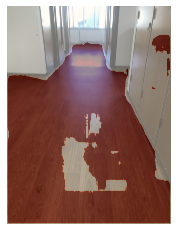

In [ ]:
plt.imshow(benchimg, cmap='gray',interpolation=None) # I would add interpolation='none'
plt.imshow(benchout, cmap='OrRd', alpha=0.4,interpolation=None) # interpolation='none'
plt.axis("off")
plt.show()

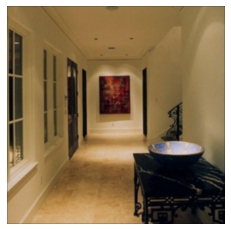

In [ ]:
testdir="/content/drive/MyDrive/separated images/testimages"

testimg_as_array,img,CimgDir = getImage_test(testdir,(720,720),1)

#test = model.predict(testimg)

mask = loaded_model.predict(testimg_as_array)

plt.imshow(img)
plt.axis("off")
plt.show()



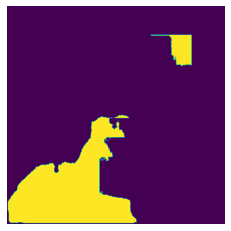

In [ ]:
mask=mask[0][:,:,0]

mask = (mask>0.5).astype("float")
plt.imshow(mask);
                
plt.axis("off")
plt.show()

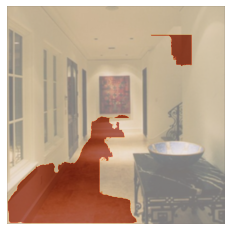

In [ ]:
plt.imshow(img, cmap='gray',interpolation=None)
plt.imshow(mask, cmap='OrRd', alpha=0.5,interpolation=None) 
plt.axis("off")
plt.show()

In [6]:
from google.colab.patches import cv2_imshow


videodir = "/content/drive/MyDrive/Path_videos"
videoname="low.mp4"
videopath = os.path.join(videodir,videoname)
print(videopath)
video = cv2.VideoCapture(videopath)


Savefile_path = "/content/detected_{}".format(videoname)
Savefile_path = Savefile_path.replace(".mp4",".avi")
fps = 30

print(Savefile_path)

fourcc = cv2.VideoWriter_fourcc("F","M","P","4")
writer = cv2.VideoWriter(Savefile_path, fourcc, fps, (720, 720))

input_image_size = (720,720)
batch_size=1

while (video.isOpened()):
    _, frame = video.read()
    img = np.zeros((batch_size, input_image_size[1], input_image_size[0], 3)).astype('float')
    print(_)
    #cv2_imshow(frame)
    if _ == True:
        frame = cv2.resize(frame, (input_image_size[1], input_image_size[0]), interpolation=cv2.INTER_AREA)

        if (len(frame.shape) == 3 and frame.shape[2] == 3):  # If it is a 3 channel RGB image
            img[0] = frame
            results = loaded_model.predict(img)
            mask = results[0][:, :, 0]
            mask = (mask > 0.5).astype("float")

            writer.write(mask)
            print("write")
        else:
            stacked_img = np.stack((frame) * 3, axis=-1)
            img[0] = stacked_img

            results = loaded_model.predict(img)
            mask = results[0][:, :, 0]
            mask = (mask > 0.5).astype("float")

            writer.write(mask)
            print("write")
    else:
      break

print("Video written")

  #key = cv2.waitKey(1)
  #if key==(27):
    #break

#TODO : resolve issue with VideoCapture.read() returning Nonetype , most likely a probelm with codecs

/content/drive/MyDrive/Path_videos/low.mp4
/content/detected_low.avi
True


error: ignored

In [ ]:
def getImage_test(img_folder, input_image_size, batch_size):
  img = np.zeros((batch_size, input_image_size[1], input_image_size[0], 3)).astype('float')
  # Read and Normalise an image
  testdir=img_folder
  testimages = next(os.walk(testdir))[2]
  CimageDir = os.path.join(testdir,random.choice(testimages))
  test_img = io.imread(CimageDir)/255.0
  # Resize
  test_img= cv2.resize(test_img,input_image_size)
  if (len(test_img.shape)==3 and test_img.shape[2]==3): # If it is a 3 channel RGB image
    img[0] = test_img
    return img,test_img,CimageDir
  else :
    stacked_img = np.stack((test_img)*3 , axis =-1)
    img[0] = stacked_img
    return img,test_img,CimageDir

In [ ]:
# Code to save the binary mask
mask_filename = "mask_{}".format(CimgDir)
mask_filename = mask_filename.replace("/content/drive/MyDrive/separated images/testimages/","")
print(mask_filename)
cv2.imwrite(mask_filename,mask*255)

mask_bowling_0071.jpg


True

In [ ]:
# Set yp training and testing with 1280x720
# TODO try with deifferent optimisers

In [ ]:
from google.colab.patches import cv2_imshow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4534  100  4534    0     0   170k      0 --:--:-- --:--:-- --:--:--  170k


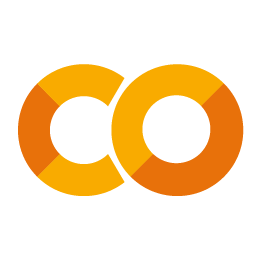

In [ ]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)